# Make global spectral slope maps for ONC and NIRS3

In [1]:
# Set output folder
out_folder = './output/'

In [2]:
import numpy as np
import math
import rasterio
from rasterio import features
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

## Calculate NUV, VIS spectral slope maps using ONC data

In [3]:
#Input file: ONC multi-band mosaic map (GeoTIFF)
in_raster = './data/hyb2_onc_mos_20181003_MascotSeparation.tif'

with rasterio.open(in_raster) as raster:
    data = raster.read()

print("Shape of data:", data.shape)
print("Data type: ", data.dtype)

Shape of data: (7, 1436, 10001)
Data type:  float32


In [4]:
# Save as GeoTIFF file
def out_raster(opath,data,rst,d_type):
    of=rasterio.open(opath , 'w', driver='COG',
                height=rst.shape[0], width=rst.shape[1], count=1,
                dtype=d_type, crs=rst.crs, transform=rst.transform, nodata = -999)

    of.write(data,1)
    of.close()


-1.0 0.026892293


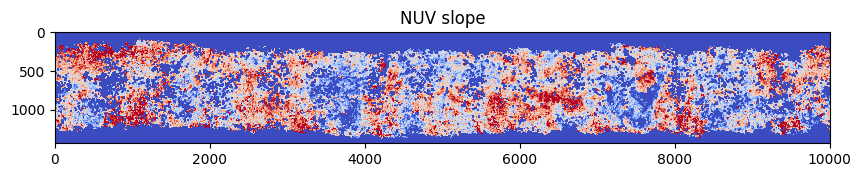

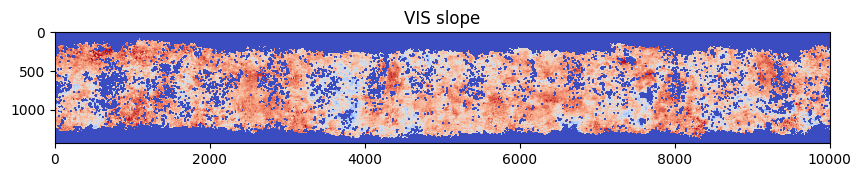

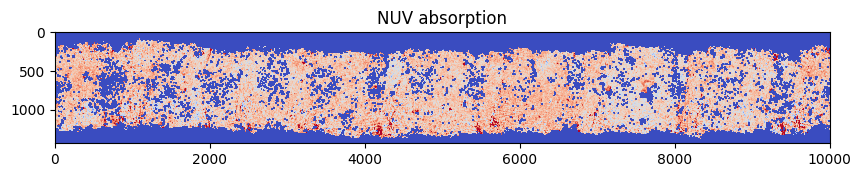

In [5]:
# ONC filter wavelengths (ul,b,v,Na,w,x,p) micron
wl = [0.40, 0.48, 0.55, 0.59, 0.70, 0.86, 0.95]

#calculate spectral slopes
# NUV(v-to-ul) spectral slope
slope_nuv = (data[2,:,:] - data[0,:,:])/data[2,:,:]/(wl[2]-wl[0])
# VIS(v-to-x) spectral slope
slope_vis = (data[5,:,:] - data[2,:,:])/data[2,:,:]/(wl[5]-wl[2])

print(np.min(data[2]), np.max(data[2]))
# NUV absorption (A_UV) is defined as a difference between NUV and VIS slopes
a_uv = slope_nuv - slope_vis

# Put -999 as nodata value
slope_nuv[data[2] == -1] = -999
slope_vis[data[2] == -1] = -999
a_uv[data[2] == -1] = -999

plt.figure(figsize = (10,4))
plt.imshow(slope_nuv, cmap='coolwarm',vmin=-0.5, vmax=-0.4)
#plt.colorbar()  # show color scale
plt.title("NUV slope")
plt.show()

plt.figure(figsize = (10,4))
plt.imshow(slope_vis, cmap='coolwarm',vmin=0, vmax=0.2)
plt.title("VIS slope")
plt.show()

plt.figure(figsize = (10,4))
plt.imshow(a_uv, cmap='coolwarm',vmin=-0.7, vmax=-0.5)
plt.title("NUV absorption")
plt.show()

In [6]:
#Output GeoTIFF files
#slope_nuv
opath = out_folder + 'ONC_MSC_slope_nuv.tif'
out_raster(opath,slope_nuv,raster,data.dtype)

#slope_vis
opath = out_folder + 'ONC_MSC_slope_vis.tif'
out_raster(opath,slope_vis,raster,data.dtype)

#a_uv
opath = out_folder + 'ONC_MSC_a_uv.tif'
out_raster(opath,a_uv,raster,data.dtype)

## Calculate NIR spectral slope using NIRS3 data
- Input file: NIRS3 L2d vector data (GeoPackage)
- Output files: I/F maps for each channel between 2.1 um to 2.5 um, Spectral slope map between 2.1 um to 2.5 um, Observation count map

In [ ]:
# Set NIRS3 spectral wavelength (micron) (ref. SIS document)
n=np.arange(128)+1
wl_all=(1230.33+18.5651*n-0.00492138*n**2)/1000.

# Input file: NIRS3 geopackage file
in_vector = './data/hyb2_nirs3_20180711_01_l2d_geo.gpkg'

# Read the input file
vector = gpd.read_file(in_vector)
df = pd.DataFrame(vector)

df.head()

In [8]:
# Get the sum of polygon values and put as a raster
def poly_to_raster(shapes,shape,transform,d_type):
    rsted = features.rasterize(shapes,
                                #out_shape = rst.shape,
                                out_shape = shape,
                                fill = 0,
                                out = None,
                                default_value = 1,
                                #transform = rst.transform,
                                transform = transform,
                                all_touched = True,
                                merge_alg=rasterio.enums.MergeAlg.add,
                                dtype = d_type)
    return rsted

# Save a raster file as GeoTIFF

def out_raster(opath,data,shape,crs,transform,cnl,d_type,nodata):
    of=rasterio.open(opath , 'w', driver='COG',
                height=shape[0], width=shape[1], count=cnl,
                dtype=d_type, crs=crs, transform=transform, nodata = nodata)
    if cnl == 1:
        of.write(data,1)
        of.close()
    else:
        of.write(data)
        of.close()

In [ ]:
# Parameter setting
# Select the wavelength bands to be used
wl_index_start = 46 # channel 47
wl_index_end = 69 # channel 70
wl_index = np.arange(wl_index_start,wl_index_end+1)

# Set the data type
d_type = 'float32'
d_type_cnt = 'int16'

#resolution [degree/pixel]
res = 1.0

# Output image size [deg]
px = 360
py = 180

# Upper left coordinate [deg]
ulx = 0
uly = 90

# Set nodata value
nodata = -999
nodata_cnt = 0

In [ ]:
# Calculate spectral slope between 2.1-2.5 micron
slopes = []

for _, row in df.iterrows():
    x = wl_all[wl_index_start:wl_index_end + 1]
    y = row.iloc[wl_index_start + 5:wl_index_end + 6].values  # Adjust for column offset
    y = y/row.iloc[wl_index_start + 5] # normalized at 2.1 micron
    # Convert y to numeric, replacing non-numeric values with NaN
    y = pd.to_numeric(y, errors='coerce')
    slope = np.polyfit(x, y, 1)[0]  # Linear fit, take the slope
    slopes.append(slope)

print(slopes)

In [ ]:
# Convert from polygon to raster
transform = Affine(res,0,ulx,0,res,uly*(-1))
width = int(px/res)
height = int(py/res)
shape = (height, width)

cnl = len(wl_index)
slope_map =np.empty((height, width),dtype = float)
cnt_arr = np.empty((height, width),dtype = float)
ave_arr = np.empty((cnl, height, width),dtype = float)

# Make average raster data for each wavelength
for i in range(cnl):
    geom = [(s,i) for s,i in zip(vector['geometry'],df.iloc[:,wl_index_start + 5 + i])]
    geom_bi = [(s,1) for s in vector['geometry']]

    cnt_arr = poly_to_raster(geom_bi,shape,transform,d_type_cnt)
    merge = poly_to_raster(geom,shape,transform,d_type)
    valid_mask = (cnt_arr != 0)
    ave_arr[i, valid_mask] = merge[valid_mask]/cnt_arr[valid_mask]
    ave_arr[i, ~valid_mask] = -999

# Make spectral slope raster data
geom = [(s,i) for s,i in zip(vector['geometry'],slopes)]
geom_bi = [(s,1) for s in vector['geometry']]

cnt_arr = poly_to_raster(geom_bi,shape,transform,d_type_cnt)
merge = poly_to_raster(geom,shape,transform,d_type)
slope_map[valid_mask] = merge[valid_mask]/cnt_arr[valid_mask]
slope_map[~valid_mask] = -999

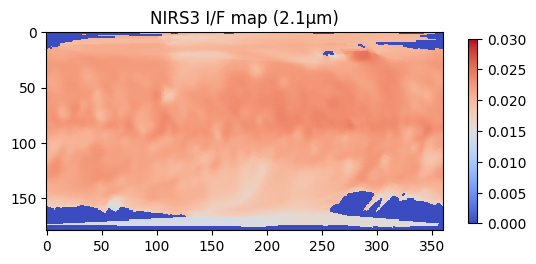

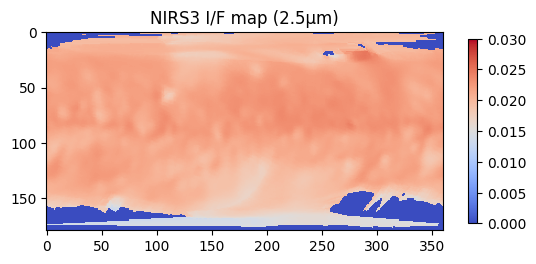

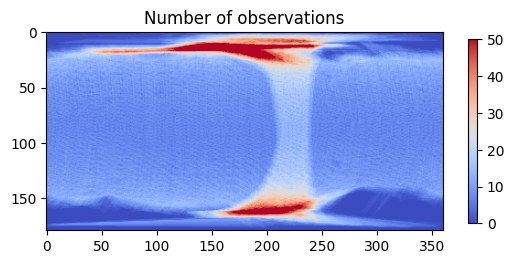

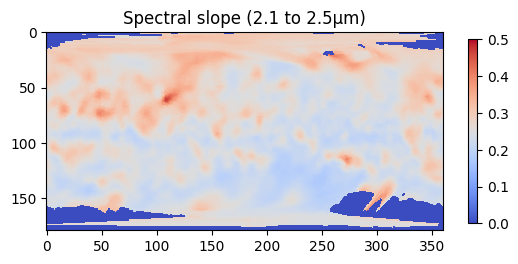

In [23]:
plt.imshow(ave_arr[0], cmap='coolwarm',vmin=0, vmax=0.03)
plt.colorbar(shrink=0.5) 
plt.title("NIRS3 I/F map (2.1μm)")
plt.show()

plt.imshow(ave_arr[1], cmap='coolwarm',vmin=0, vmax=0.03)
plt.colorbar(shrink=0.5) 
plt.title("NIRS3 I/F map (2.5μm)")
plt.show()

plt.imshow(cnt_arr, cmap='coolwarm',vmin=0, vmax=50)
plt.title("Number of observations")
plt.colorbar(shrink=0.5)
plt.show()

plt.imshow(slope_map, cmap='coolwarm', vmin=0, vmax=0.5)
plt.title("Spectral slope (2.1 to 2.5μm)")
plt.colorbar(shrink=0.5)
plt.show()

In [24]:

# Set output file paths
day = df.iloc[0,0][:10]
opath = out_folder + day + '_ave_' + str(res) + 'd.tif'
opath_cnt = out_folder + day + '_cnt_' + str(res) + 'd.tif'
opath_slope = out_folder + day + '_slp_' + str(res) + 'd.tif'


# Output files using the CRS from input file
crs = vector.crs
out_raster(opath,ave_arr,shape,crs,transform,cnl,d_type,nodata)
out_raster(opath_cnt,cnt_arr,shape,crs,transform,1,d_type_cnt,nodata_cnt)
out_raster(opath_slope,slope_map,shape,crs,transform,1,d_type,nodata)